In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from sklearn.metrics import confusion_matrix

from keras.preprocessing.image import ImageDataGenerator, array_to_img
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.layers import Dropout
#from keras.layers import BatchNormalization




Using TensorFlow backend.


In [2]:
from google.colab import drive

drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/xray_files/adults/'  #change dir to your project folder

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
hyper_dimension = 500
hyper_epochs = 10
hyper_batch_size = 6
hyper_feature_maps = 32
hyper_channels = 1
hyper_mode = 'grayscale'

In [4]:

# Initializing the CNN
classifier = Sequential()


#https://bmcgenomics.biomedcentral.com/articles/10.1186/s12864-019-5546-z
# based on this article a 3L1_64U layer gives the highest accuracy on the most datasets in average. Therefore I build the module based on this theory.
# I used the BatchNormalization function to stadarize the imputs and reduce the epochs needed to train teh CNN
# Dropouts have been utilized to reduce the risk of over fitting


# Convolution & pooling - First convolution layer
classifier.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(hyper_dimension,
                                     hyper_dimension,
                                     hyper_channels)))
#classifier.add(BatchNormalization())
classifier.add(MaxPooling2D(pool_size=(2, 2)))
classifier.add(Dropout(0.2))


# Convolution & pooling - Second convolution layer
classifier.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
#classifier.add(BatchNormalization())
classifier.add(MaxPooling2D(pool_size=(2, 2)))
classifier.add(Dropout(0.2))


# Convolution & pooling - Third convolution layer
classifier.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
#classifier.add(BatchNormalization())
classifier.add(MaxPooling2D(pool_size=(2, 2)))
classifier.add(Dropout(0.2))

# Flattening
classifier.add(Flatten())

# Full connection
classifier.add(Dense(128, activation='relu'))
#classifier.add(BatchNormalization())
classifier.add(Dropout(0.2))
# Second node layer
classifier.add(Dense(128, activation='relu'))
#classifier.add(BatchNormalization())
classifier.add(Dropout(0.2))
#third node layer
classifier.add(Dense(64, activation='relu'))
#classifier.add(BatchNormalization())
classifier.add(Dropout(0.2))

#output layer with softmax for probaibility
classifier.add(Dense(2, activation='softmax'))

# Compiling the CNN
classifier.compile(optimizer = 'adam',
                   loss = 'categorical_crossentropy',
                   metrics = ['accuracy'])

In [5]:
#showing a summary of the above build network
classifier.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 498, 498, 64)      640       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 249, 249, 64)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 249, 249, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 247, 247, 64)      36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 123, 123, 64)      0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 123, 123, 64)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 121, 121, 64)     

In [6]:
# Creating training and validation image flows

train_gen = ImageDataGenerator(rescale = 1./255,
                               shear_range = 0.2,
                               zoom_range = 0.2,
                               vertical_flip = True)

val_gen = ImageDataGenerator(rescale = 1./255)

train_set = train_gen.flow_from_directory(f'{root_path}train',
                                          target_size = (hyper_dimension,
                                                         hyper_dimension),
                                          batch_size = hyper_batch_size,
                                          class_mode = 'categorical',
                                          color_mode = hyper_mode)

val_set = val_gen.flow_from_directory(f'{root_path}val',
                                      target_size = (hyper_dimension,
                                                     hyper_dimension),
                                      batch_size = hyper_batch_size,
                                      class_mode = 'categorical',
                                      color_mode = hyper_mode)

Found 800 images belonging to 2 classes.
Found 119 images belonging to 2 classes.


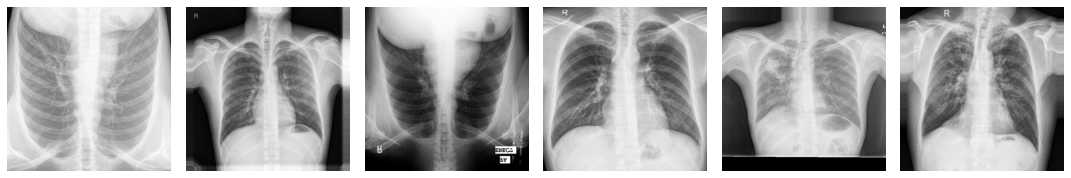

In [7]:
# Visualizing images in the first training set batch 

image_batch = train_set[0][0]

plt.figure(figsize=(20,5))
for i in range(len(image_batch)):
    plt.subplot(2,8,i+1)
    pil_img = array_to_img(image_batch[i])
    plt.imshow(pil_img,cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
# Fitting the model

results = classifier.fit_generator(train_set,
                                   steps_per_epoch = len(train_set),
                                   epochs = hyper_epochs,
                                   validation_data = val_set,
                                   validation_steps = len(val_set))

Epoch 1/10
134/134 [==============================] - 571s 4s/step - loss: 0.7712 - accuracy: 0.4737 - val_loss: 0.6941 - val_accuracy: 0.5294
Epoch 2/10
 48/134 [=========>....................] - ETA: 3:32 - loss: 0.6935 - accuracy: 0.5035

In [ ]:
# Creating test image flow

test_gen = ImageDataGenerator(rescale = 1./255)

test_set = test_gen.flow_from_directory(f'{root_path}/test',
                                        target_size = (hyper_dimension,
                                                       hyper_dimension),
                                        batch_size = 1,
                                        class_mode = 'categorical',
                                        color_mode = hyper_mode,
                                        shuffle=False)




In [ ]:
# Making predictions (in form of a probability tuple)

predictions = classifier.predict(test_set)

In [ ]:
#clasify the prediction to its class

y_classes = predictions.argmax(axis=-1)

In [ ]:
# Confusion matrix

cm = pd.DataFrame(data=confusion_matrix(test_set.classes, y_classes, labels=[0, 1]),
                  index=["Actual Normal", "Actual Pneumonia"],
                  columns=["Predicted Normal", "Predicted Pneumonia"])
cm

In [ ]:
#save the trained model
file_name = "3L64u3Ln2sm_adult"
classifier.save(f'{root_path}{file_name}.h5') 

In [ ]:
# Fitting the model

results = classifier.fit_generator(train_set,
                                   steps_per_epoch = len(train_set),
                                   epochs = hyper_epochs,
                                   validation_data = val_set,
                                   validation_steps = len(val_set))

In [ ]:
#save the trained model
classifier.save(f'{root_path}{file_name}.h5') 

In [ ]:
# Fitting the model

results = classifier.fit_generator(train_set,
                                   steps_per_epoch = len(train_set),
                                   epochs = hyper_epochs,
                                   validation_data = val_set,
                                   validation_steps = len(val_set))

#save the trained model
classifier.save(f'{root_path}{file_name}.h5') 

In [ ]:
# Fitting the model

results = classifier.fit_generator(train_set,
                                   steps_per_epoch = len(train_set),
                                   epochs = hyper_epochs,
                                   validation_data = val_set,
                                   validation_steps = len(val_set))

#save the trained model
classifier.save(f'{root_path}{file_name}.h5') 

In [ ]:
# Fitting the model

results = classifier.fit_generator(train_set,
                                   steps_per_epoch = len(train_set),
                                   epochs = hyper_epochs,
                                   validation_data = val_set,
                                   validation_steps = len(val_set))

#save the trained model
classifier.save(f'{root_path}{file_name}.h5') 

In [ ]:
# Fitting the model

results = classifier.fit_generator(train_set,
                                   steps_per_epoch = len(train_set),
                                   epochs = hyper_epochs,
                                   validation_data = val_set,
                                   validation_steps = len(val_set))

#save the trained model
classifier.save(f'{root_path}{file_name}.h5') 

In [ ]:
# Fitting the model

results = classifier.fit_generator(train_set,
                                   steps_per_epoch = len(train_set),
                                   epochs = hyper_epochs,
                                   validation_data = val_set,
                                   validation_steps = len(val_set))

#save the trained model
classifier.save(f'{root_path}{file_name}.h5') 

In [ ]:
# Fitting the model

results = classifier.fit_generator(train_set,
                                   steps_per_epoch = len(train_set),
                                   epochs = hyper_epochs,
                                   validation_data = val_set,
                                   validation_steps = len(val_set))

#save the trained model
classifier.save(f'{root_path}{file_name}.h5') 

In [ ]:
# Fitting the model

results = classifier.fit_generator(train_set,
                                   steps_per_epoch = len(train_set),
                                   epochs = hyper_epochs,
                                   validation_data = val_set,
                                   validation_steps = len(val_set))

#save the trained model
classifier.save(f'{root_path}{file_name}.h5') 

In [ ]:
# Fitting the model

results = classifier.fit_generator(train_set,
                                   steps_per_epoch = len(train_set),
                                   epochs = hyper_epochs,
                                   validation_data = val_set,
                                   validation_steps = len(val_set))

#save the trained model
classifier.save(f'{root_path}{file_name}.h5') 